<a href="https://colab.research.google.com/github/vvviet2908/Coursera_Capstone/blob/master/Battle_of_Neighborhood_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Ho Chi Minh City (Vietnamese: Thành phố Hồ Chí Minh), also commonly referred to as Saigon, is the largest city of Vietnam. Located in southeastern Vietnam, the city surrounds the Saigon River and covers about 2,061 square kilometres (796 square miles). Ho Chi Minh City is the economic and financial centre of Vietnam, and plays an important role in the country's culture and scientific developments.

# Business Problem
  A Local Coffee Shop want to open their first store in Ho Chi Minh City. The new store would be located in a ideal place with crowded customers, acceptable housing price, and low density of other coffee shop 
  
  By using Data Science, they can give good answers to the following questions:

  * Where should we locate the shop?
  * Which districts have the lowest housing price?
  * How many other coffee shop in each districts?
  * Which districts have low number of coffee shop, and big population?


# Data
To find the ideal place for the new coffee shop, we need the following data:
  * List of Districts in Ho Chi Minh City contains district names, and their population, area, density from wikipedia (https://en.wikipedia.org/wiki/Ho_Chi_Minh_City)
  * List of Housing Price in Ho Chi Minh City from Mogi (https://mogi.vn/gia-nha-dat)
  * Foursquare API to get the venues 

# Methodology
* First, by using the library BeautifulSoup to scrapt the data from wikipedia, the list of districts had been collected. 

* Then, the density had been calculated by the substraction of population and area.

* geopy.geocoders.Nominatim had been used to get the coordinates of districts and add them to the main data frame.

* The library Folium had been used to sketch the map of the districts.

* Foursquare API to explore the venues in each district and segment the districts based on them.

* Clustering the venues "Coffee Shop" by the algorithm K-Mean Clustering from the library Scikit-Learn 

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# find the distances
from scipy.spatial.distance import cdist

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
! pip install unidecode
from unidecode import unidecode

print('Libraries imported.')

Libraries imported.


## **1/Load Dataset**

**Scrapt the Wikipedia page**

In [2]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [3]:
df_hcm = pd.DataFrame(res_hcm, columns=["District", "Ward",
                        "Area (km2)", "", "", "", "", "Population", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population"] = (
                            df_hcm["Population"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Ward,Area (km2),Population,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


**Get The Housing Price**

In [4]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [5]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [6]:

df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (Million VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (Million VND)"] = ( df_housing_price["Average Housing Price (Million VND)"]
                                                 .str.replace("triệu/m2", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
df_housing_price

,District,Average Housing Price (Million VND)
0,1,418
1,2,81.4
2,3,265
3,4,109
4,5,254
5,6,114
6,7,90.6
7,8,70.9
8,9,48.8
9,10,211


In [7]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')

df

,District,Ward,Area (km2),Population,Density (pop/m2),Average Housing Price (Million VND)
0,1,10 wards,7.73,193632,25049.418,418
1,2,11 wards,49.74,147168,2958.745,81.4
2,3,14 wards,4.92,196333,39905.081,265
3,4,15 wards,4.18,186727,44671.531,109
4,5,15 wards,4.27,178615,41830.211,254
5,6,14 wards,7.19,258945,36014.604,114
6,7,10 wards,35.69,310178,8690.894,90.6
7,8,16 wards,19.18,431969,22521.846,70.9
8,9,13 wards,114,290620,2549.298,48.8
9,10,15 wards,5.72,238558,41705.944,211


**Get the coordinates of the city**

In [8]:
def find_coor(name):
    address = name
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location:
       latitude = location.latitude
       longitude = location.longitude
    return [latitude, longitude]

In [9]:
# For District 1 to 11 (numbers)
coords = [find_coor("District " + dist + ", Ho Chi Minh City, Vietnam") for dist in df["District"].iloc[:11].tolist()]

coords = coords + [find_coor("District 12, Vietnam")]
coords = coords + [find_coor("Go Vap, Ho Chi Minh City, Vietnam")]
# For the other districts (letters)
coords = coords + [find_coor(dist + " District" + ", Ho Chi Minh City, Vietnam") for dist in df["District"].iloc[13:].tolist()]


In [10]:
df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Ward,Area (km2),Population,Density (pop/m2),Average Housing Price (Million VND),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,418,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,81.4,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,265,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,109,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,254,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,114,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,90.6,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,70.9,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,48.8,10.849307,106.802055
9,10,15 wards,5.72,238558,41705.944,211,10.773198,106.667833


**Map Plotting**

In [11]:
[hcm_lat, hcm_long] = find_coor("Ho Chi Minh City, Vietnam")
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.7758439, 106.7017555.


In [12]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

**Define Foursquare Credentials and Version**


In [13]:
CLIENT_ID = 'CW2F4KL1QETBR1UVB4OSW35KLNHKGS3IEG4OEMPNH3DXV5PG' # your Foursquare ID
CLIENT_SECRET = 'OCHOD2C50RGSXFMJJ3QPVHPUX4BFMRZVJZTSEEAJGJI3QTJ0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CW2F4KL1QETBR1UVB4OSW35KLNHKGS3IEG4OEMPNH3DXV5PG
CLIENT_SECRET:OCHOD2C50RGSXFMJJ3QPVHPUX4BFMRZVJZTSEEAJGJI3QTJ0


**Let's explore the first neighborhood in our dataframe.**

Get the venues from the API

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Assign to the dataframe

In [15]:

hcm_venues = getNearbyVenues(names=df['District'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude']
                            )

In [16]:

hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
2,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
3,1,10.77454,106.699184,Quán Lộc Thành,10.772472,106.698441,Vietnamese Restaurant
4,1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store


## 2/Exploring the data

In [17]:
df2=hcm_venues['Venue Category'].str.contains('Coffee Shop')
hcm_cfshop=hcm_venues[df2]
hcm_cfshop.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
17,1,10.77454,106.699184,Starbucks (Starbucks Coffee Rex Hotel),10.775614,106.700530,Coffee Shop
27,1,10.77454,106.699184,Boa cafe,10.775238,106.702770,Coffee Shop
33,1,10.77454,106.699184,Starbucks,10.773784,106.700950,Coffee Shop
35,1,10.77454,106.699184,Starbucks Reserve,10.778961,106.698185,Coffee Shop
80,1,10.77454,106.699184,The Workshop Cafe,10.773551,106.705586,Coffee Shop


In [18]:
hcm_venues_group = hcm_cfshop.groupby('District').count().reset_index()
hcm_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,6,6,6,6,6,6
1,10,9,9,9,9,9,9
2,3,8,8,8,8,8,8
3,4,2,2,2,2,2,2
4,5,5,5,5,5,5,5
5,7,2,2,2,2,2,2
6,8,3,3,3,3,3,3
7,Binh Thanh,3,3,3,3,3,3
8,Go Vap,1,1,1,1,1,1
9,Phu Nhuan,9,9,9,9,9,9


Text(0, 0.5, 'Number of venues')

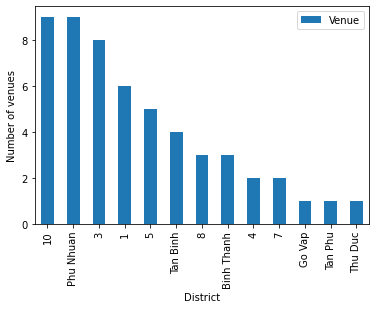

In [19]:
ax = hcm_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

In [20]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped_cfshop = hcm_grouped[["District", "Coffee Shop"]]
hcm_grouped_cfshop

,District,Coffee Shop
0,1,0.060000
1,10,0.128571
2,11,0.000000
3,12,0.000000
4,2,0.000000
5,3,0.080000
6,4,0.038462
7,5,0.071429
8,6,0.000000
9,7,0.057143


## 3/K-Means Clustering

Choosing number of K

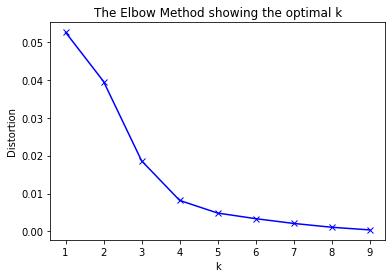

In [21]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

hcm_cafe_clustering = hcm_grouped_cfshop.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hcm_cafe_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(hcm_cafe_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / hcm_cafe_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [22]:
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(hcm_cafe_clustering)

In [23]:
df_cfshop = hcm_grouped_cfshop.copy()
df_cfshop["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_cfshop = df_cfshop.join(df.set_index("District"), on="District")

# sort the table by cluster labels
df_cfshop.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_cfshop = df_cfshop.drop(["Ward", "Area (km2)"], axis=1)

# change to numeric date type
df_cfshop['Average Housing Price (Million VND)'] = df_cfshop['Average Housing Price (Million VND)'].astype(float)

df_cfshop

,District,Coffee Shop,Cluster Labels,Population,Density (pop/m2),Average Housing Price (Million VND),Latitude,Longitude
2,11,0.000000,0,230596,44863.035,164.0,10.764208,106.643282
3,12,0.000000,0,510326,9668.928,46.5,10.867233,106.653930
4,2,0.000000,0,147168,2958.745,81.4,10.791116,106.736729
6,4,0.038462,0,186727,44671.531,109.0,10.759243,106.704890
8,6,0.000000,0,258945,36014.604,114.0,10.746928,106.634495
11,9,0.000000,0,290620,2549.298,48.8,10.849307,106.802055
12,Binh Tan,0.000000,0,686474,13229.408,60.0,10.749809,106.605664
10,8,0.300000,1,431969,22521.846,70.9,10.740400,106.665843
0,1,0.060000,2,193632,25049.418,418.0,10.774540,106.699184
16,Tan Binh,0.108108,2,459029,20510.679,145.0,10.797979,106.653805




*   Cluster 0: There are not many coffee shops in these districts.
*   Cluster 1: The number of coffee shops in these districts is medium.
*   Cluster 2: The number of coffee shops in these districts is low.



**Visualize the Cluster**

In [24]:

# create map
map_clusters = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cfshop['Latitude'], 
        df_cfshop['Longitude'], 
        df_cfshop['District'], 
        df_cfshop['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Examine the range of Average Housing Price (AHP)**


Range of AHP:

1/Low: 30mVND < AHP < 50mVND.

2/Medium: 50mVND < AHP < 100mVND.

3/High: 100mVND < AHP < 200mVND.

4/Very High: AHP > 200mVND


In [25]:
count, division = np.histogram(df_cfshop['Average Housing Price (Million VND)'], bins = [30, 50, 100, 200, 300])

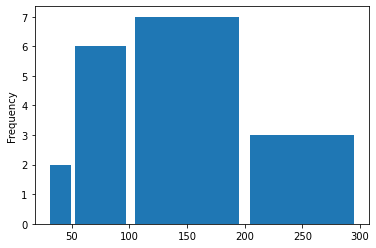

In [26]:
df_cfshop['Average Housing Price (Million VND)'].plot.hist(bins=division, rwidth=0.9)

In [27]:
count

array([2, 6, 7, 3])

In [28]:
def classify_ahp(price):
    if price <= 50:
        return "Low"
    elif price <= 100:
        return "Medium"
    elif price <= 200:
        return "High"
    else:
        return "Very High"

In [29]:
df_cfshop["AHP Level"] = df_cfshop["Average Housing Price (Million VND)"].apply(classify_ahp)
df_cfshop

,District,Coffee Shop,Cluster Labels,Population,Density (pop/m2),Average Housing Price (Million VND),Latitude,Longitude,AHP Level
2,11,0.000000,0,230596,44863.035,164.0,10.764208,106.643282,High
3,12,0.000000,0,510326,9668.928,46.5,10.867233,106.653930,Low
4,2,0.000000,0,147168,2958.745,81.4,10.791116,106.736729,Medium
6,4,0.038462,0,186727,44671.531,109.0,10.759243,106.704890,High
8,6,0.000000,0,258945,36014.604,114.0,10.746928,106.634495,High
11,9,0.000000,0,290620,2549.298,48.8,10.849307,106.802055,Low
12,Binh Tan,0.000000,0,686474,13229.408,60.0,10.749809,106.605664,Medium
10,8,0.300000,1,431969,22521.846,70.9,10.740400,106.665843,Medium
0,1,0.060000,2,193632,25049.418,418.0,10.774540,106.699184,Very High
16,Tan Binh,0.108108,2,459029,20510.679,145.0,10.797979,106.653805,High


## Conclusion

From all above results, we conclude that, the best place for us to set up a new coffee shop is in **district 12** because there are a lot of people living there (high density), there are not many already-working coffee shop (cluster 0) and the average housing price is low.